Best Hyperparameters:  {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best Cross-validation Accuracy: 0.82


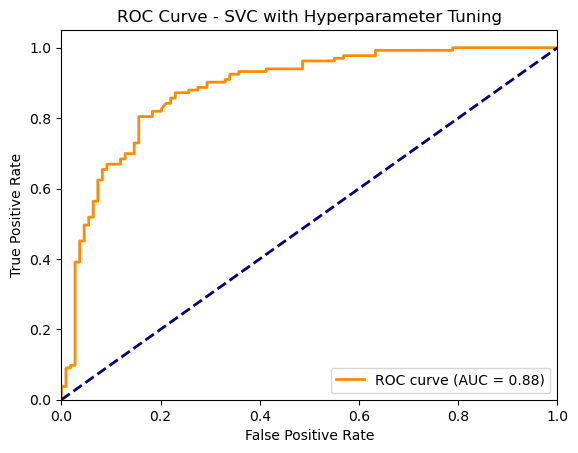

Test Accuracy: 0.87
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

# Load the clinical dataset
clinical_data = pd.read_csv('../datasets/clinical_dataset.csv')

# Split the clinical dataset into X and Y
Xclinical = clinical_data.drop('output', axis=1)
Yclinical = clinical_data['output']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(Xclinical, Yclinical, test_size=0.2, random_state=42)

# Define the preprocessor
clinical_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns)
    ])

# Define the SVC model with probability=True for ROC curve generation
svc = SVC(probability=True, random_state=42)

# Create a pipeline that includes the preprocessor and the SVC classifier
pipeline = Pipeline(steps=[
    ('preprocessor', clinical_preprocessor),
    ('svc', svc)
])

# Define the hyperparameters to tune
param_grid = {
    'svc__C': [0.1, 1, 10, 100],                  # Regularization parameter
    'svc__kernel': ['linear', 'rbf'],             # Kernel types (linear and RBF)
    'svc__gamma': ['scale', 'auto']               # Kernel coefficient for 'rbf' kernel
}

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model using GridSearchCV
grid_search.fit(X_train, Y_train)

# Get the best parameters and the best score from GridSearchCV
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Cross-validation Accuracy: {:.2f}".format(grid_search.best_score_))

# Use cross_val_predict to get the predicted probabilities for each fold (best estimator)
cv = StratifiedKFold(n_splits=5)
y_pred_proba = cross_val_predict(grid_search.best_estimator_, X_train, Y_train, cv=cv, method='predict_proba')

# Use the second column which contains the probabilities for the positive class (i.e., class 1)
y_pred_proba_positive = y_pred_proba[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(Y_train, y_pred_proba_positive)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVC with Hyperparameter Tuning')
plt.legend(loc="lower right")
plt.show()

# Evaluate the best model on the test set
Y_pred = grid_search.best_estimator_.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("Test Accuracy: {:.2f}".format(accuracy))
print("Classification Report:\n", classification_report(Y_test, Y_pred))
